In [1]:
import pandas as pd # Manejo de bases de datos
import geopandas as gpd # Manejo de bases de datos geográficas
import numpy as np # Funciones numéricas
import matplotlib.pyplot as plt # Gráficas
import seaborn as sns # Gráficas
import datetime as dt
import folium
import unicodedata
import geojson
import urllib, json

from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split
from sklearn import neighbors
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier

from shapely.geometry import LineString, Point
from geopandas.tools import sjoin

### Get Training set from previously performed UTAM clustering

In [3]:
# Peak contagion dates from Bogotá
peak_dates = ['01/05/2020' ,'01/08/2020', '01/11/2020', '10/01/2021', '01/03/2021', '01/05/2021',
             '10/06/2021', '01/09/2021']

peak_dates2 = ['01-05-2020' ,'01-08-2020', '01-11-2020', '10-01-2021', '01-03-2021', '01-05-2021',
             '10-06-2021', '01-09-2021']

peak_dates3 = peak_dates2

ClustDF_list = []
base_path = '/home/ubuntu/javeriana/MOTUS-PUJ/Step_2/2_ML_Preps/Test_Clustering_DF/'
# Load files
for k in range(len(peak_dates3)):
    file_name = 'date_'+peak_dates3[k]+'.pkl'
    temp = pd.read_pickle(base_path+file_name, compression='gzip')
    temp = gpd.GeoDataFrame(temp)
    ClustDF_list.append(temp)
    ClustDF_list[k].crs = "EPSG:4326"
    ClustDF_list[k].to_crs(epsg=4326, inplace=True)
    del temp
    
ClustDFmat_list = []
# Drop un needed cols
for i in range(len(peak_dates3)):
    ClustDFmat_list.append(ClustDF_list[i].copy())
    ClustDFmat_list[i].drop(columns={'LOCNombre', 'PopLoc','UTAM', 'LOCid', 'UTAMNombre', 'geometry', 
                                     'ESTRATOPre', 'PopDen[p/km2]', 'N_Hosp', 'N_IPS', 'N_ITur', 'N_SITP', 
                                     'N_Ecomer', 'Total trips'}, inplace=True)

In [4]:
X_list = [] # observation list

for i in range(len(ClustDFmat_list)):
    X_list.append(ClustDFmat_list[i].to_numpy()) #from DF to matrix
    
# Kmeans, 2 clusters, bi chars
n_clust = 3
kmeans_model_list = []
kmeans_model_labels = []
#Train model 
global_kmeans = KMeans(n_clusters=n_clust, random_state=10).fit(X_list[3])

for i in range(len(X_list)):
    #Predict Clusters
    kmeans_model_labels.append(global_kmeans.predict(X_list[i]))
    
kmeans_DF_list = ClustDF_list.copy()
# Add predicted labels to DataFrame
for i in range(len(kmeans_DF_list)):
    kmeans_DF_list[i]['kmeans_label_full'] = kmeans_model_labels[i]

In [5]:
# Check the risk each cluster belongs to with a defined score as the sum of the mean normalized RT 
# and active cases in each cluster
for i in range(len(kmeans_DF_list)):
    for j in range(n_clust):
        temp = kmeans_DF_list[i][ kmeans_DF_list[i]['kmeans_label_full'] == j ]
        
        tot_case = sum(temp['UTAM_cases'+peak_dates3[i]].values.tolist())/len(temp['UTAM_cases'+peak_dates3[i]].values.tolist())
        mean_rt = sum(temp['local_rt_'+peak_dates3[i]].values.tolist())/len(temp['local_rt_'+peak_dates3[i]].values.tolist())
        score = tot_case+mean_rt
        
        print('Date: ',peak_dates3[i],'\n',
             'Cluster: ',j,'\n',
             'Score: ',score,'\n')
    print('\n')

Date:  01-05-2020 
 Cluster:  0 
 Score:  0.44984276893972697 

Date:  01-05-2020 
 Cluster:  1 
 Score:  1.0742170813666823 

Date:  01-05-2020 
 Cluster:  2 
 Score:  0.7787223890781001 



Date:  01-08-2020 
 Cluster:  0 
 Score:  0.543648420668687 

Date:  01-08-2020 
 Cluster:  1 
 Score:  1.229762648472319 

Date:  01-08-2020 
 Cluster:  2 
 Score:  0.8212921267124227 



Date:  01-11-2020 
 Cluster:  0 
 Score:  0.5337476594245056 

Date:  01-11-2020 
 Cluster:  1 
 Score:  1.2698684785419478 

Date:  01-11-2020 
 Cluster:  2 
 Score:  0.8411259336946159 



Date:  10-01-2021 
 Cluster:  0 
 Score:  0.5124724770294031 

Date:  10-01-2021 
 Cluster:  1 
 Score:  1.2122277502324275 

Date:  10-01-2021 
 Cluster:  2 
 Score:  0.8065807243984281 



Date:  01-03-2021 
 Cluster:  0 
 Score:  0.5287251266832589 

Date:  01-03-2021 
 Cluster:  1 
 Score:  1.2669131872413129 

Date:  01-03-2021 
 Cluster:  2 
 Score:  0.8598623477266922 



Date:  01-05-2021 
 Cluster:  0 
 Score:  0.53

In [6]:
# Stratify risk 

# 0cluster -> low
# 1cluster -> high
# 2cluster -> med
#Function used to stratify risk
def stratRisk(etq):
    if etq == 0:
        return 0
    
    elif etq == 1:
        return 2
    
    elif etq == 2:
        return 1
    
# Stratify risk
for i in range(len(kmeans_DF_list)):
    kmeans_DF_list[i]['Strat_risk'] = kmeans_DF_list[i].apply(lambda row: stratRisk(row['kmeans_label_full']) ,axis=1)

In [7]:
# Characteristic matrix and labels
Xc_list = []
Yl_list = []

for i in range(len(ClustDFmat_list)):
    Xc_list.append(ClustDFmat_list[i].to_numpy())
    Yl_list.append(kmeans_DF_list[i]['Strat_risk'].to_numpy())

In [8]:
# labels for specific date
ClustDFmat_list[6]['labels'] = kmeans_DF_list[6]['Strat_risk']
# This specific date is used to train classification model
ClustDFmat_list[6].to_pickle('/home/ubuntu/javeriana/MOTUS-PUJ/Step_2/2_ML_Preps/Outputs/TrainClass.pkl')

### k Nearest Neighbors classifier

In [9]:
# select date
sd = 7
# Partition train and test batches
X_train, X_test, y_train, y_test = train_test_split(Xc_list[sd], Yl_list[sd], test_size=0.65)

In [10]:
# Train k Nearest Neighbors classifier 
Nclf = neighbors.KNeighborsClassifier(n_neighbors=16, weights='distance', algorithm='auto')
Nclf.fit(X_train, y_train)

#Predict risk for utams in order to check confusion matrix
pred_label = Nclf.predict(X_test)

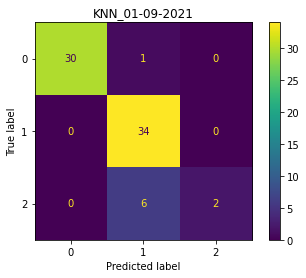

In [11]:
#Confusion matrix
cm = confusion_matrix(y_test, pred_label)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.title('KNN_'+peak_dates3[sd], fontsize=12)
plt.figure(1, figsize=[8, 8])

cm_name = 'date_'+peak_dates3[sd]
plt.savefig('/home/ubuntu/javeriana/MOTUS-PUJ/Step_2/2_ML_Preps/Outputs/'+cm_name)

### Neural Network Classifier (Multi Layer Percepron)

In [13]:
# select date
sd = 5
# Partition train and test batches
X_train, X_test, y_train, y_test = train_test_split(Xc_list[sd], Yl_list[sd], test_size=0.65)

In [14]:
# Train 
NN = MLPClassifier(solver='lbfgs', alpha=1e-5, hidden_layer_sizes=(), random_state=1)
NN.fit(X_train, y_train)
# Predict
pred_label = NN.predict(X_test)

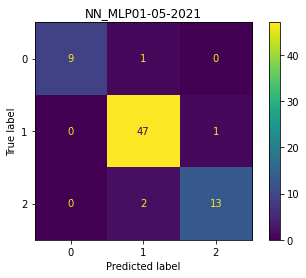

In [15]:
#Confusion matrix
cm = confusion_matrix(y_test, pred_label)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.title('NN_MLP'+peak_dates3[sd], fontsize=12)
plt.figure(1, figsize=[8, 8])

cm_name = 'date_'+peak_dates3[sd]
plt.savefig('/home/ubuntu/javeriana/MOTUS-PUJ/Step_2/2_ML_Preps/Outputs/'+cm_name)

### Random Forest

In [16]:
# select date
sd = 7
# Partition train and test batches
X_train, X_test, y_train, y_test = train_test_split(Xc_list[sd], Yl_list[sd], test_size=0.65)

In [17]:
# Fit model
rf = RandomForestClassifier(random_state=0)
rf.fit(X_train, y_train)
# Predict
pred_label = rf.predict(X_test)

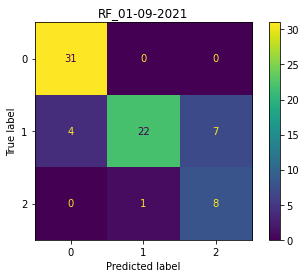

In [18]:
#Confusion matrix
cm = confusion_matrix(y_test, pred_label)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.title('RF_'+peak_dates3[sd], fontsize=12)
plt.figure(1, figsize=[8, 8])

cm_name = 'date_'+peak_dates3[sd]
plt.savefig('/home/ubuntu/javeriana/MOTUS-PUJ/Step_2/2_ML_Preps/Outputs/'+cm_name)

### Predict city block strat risk and create a map

In [19]:
# Peak contagion dates
peak_dates = ['01/05/2020' ,'01/08/2020', '01/11/2020', '10/01/2021', '01/03/2021', '01/05/2021',
             '10/06/2021', '01/09/2021']

peak_dates2 = ['01-05-2020' ,'01-08-2020', '01-11-2020', '10-01-2021', '01-03-2021', '01-05-2021',
             '10-06-2021', '01-09-2021']

peak_dates3 = peak_dates2

In [20]:
# Read previously prepared classification DFs
ClassDF_list = []
base_path = '/home/ubuntu/javeriana/MOTUS-PUJ/Step_2/2_ML_Preps/Test_Classification_DF/'

for k in range(len(peak_dates3)):
    file_name = 'date_'+peak_dates3[k]+'.pkl'
    temp = pd.read_pickle(base_path+file_name, compression='gzip')
    temp = gpd.GeoDataFrame(temp)
    ClassDF_list.append(temp)
    ClassDF_list[k].crs = "EPSG:4326"
    ClassDF_list[k].to_crs(epsg=4326, inplace=True)
    ClassDF_list[k] = ClassDF_list[k][ ClassDF_list[k]['Area_km2'] < 0.4 ]
    ClassDF_list[k].reset_index(drop=True, inplace=True)
    del temp

In [21]:
ClassDFmat_list = []
# Drop cols to getrequired matrices to perform classification
for i in range(len(peak_dates3)):
    ClassDFmat_list.append(ClassDF_list[i].copy())
    ClassDFmat_list[i].drop(columns={'MANCODIGO', 'ppl_block', 'Area_km2', 'BlockPopDen', 'geometry',
                                    'N_Hosp', 'N_IPS', 'N_ITur', 'N_SITP', 'N_Ecomer', 'UTAM',
                                    'LOCid', 'ESTRATOPre', 'total_trips'}, inplace=True)

## NN MLP prediction

In [22]:
# make classification prediction with NN
block_pred_label = []
X_list = []

#Change DFs to matrices for selected dates
for i in range(len(ClassDFmat_list)):
    X_list.append(ClassDFmat_list[i].to_numpy())
    
# Train model 
NN = MLPClassifier(solver='lbfgs', alpha=1e-5, hidden_layer_sizes=(), random_state=1)
NN.fit(Xc_list[6], Yl_list[6])

# predict labels
for i in range(len(X_list)):
    block_pred_label.append(NN.predict(X_list[i]))

# add labels to DFs in list
for i in range(len(ClassDF_list)):
    ClassDF_list[i]['risk_strat'] = block_pred_label[i]

In [ ]:
# Watch predictions and save figure if wanted
for i in range(len(ClassDF_list)):
    ClassDF_list[i].plot(column='risk_strat', cmap='YlOrRd', figsize=(8,12), legend=True);
    plt.title('Stratified risk per city block MLPNN, date: '+peak_dates3[i], fontsize=14);
    fig_name = 'date_'+peak_dates3[i]+'_.png'
    #plt.savefig('/home/ubuntu/javeriana/MOTUS-PUJ/Step_2/2_ML_Preps/Outputs/'+fig_name)

## KNN Prediction

In [24]:
# make classification prediction with KNN
block_pred_label = []

# Train model
Nclf = neighbors.KNeighborsClassifier(n_neighbors=16, weights='distance', algorithm='auto')
Nclf.fit(Xc_list[6], Yl_list[6])
    
for i in range(len(X_list)):
    block_pred_label.append(Nclf.predict(X_list[i]))
    
for i in range(len(ClassDF_list)):
    ClassDF_list[i]['risk_strat'] = block_pred_label[i]

In [ ]:
# Watch predictions and save figure if wanted
for i in range(len(ClassDF_list)):
    ClassDF_list[i].plot(column='risk_strat', cmap='YlOrRd', figsize=(8,12), legend=True);
    plt.title('Stratified risk per city block KNN, date: '+peak_dates3[i], fontsize=14);
    fig_name = 'date_'+peak_dates3[i]+'_.png'
    #plt.savefig('/home/ubuntu/javeriana/MOTUS-PUJ/Step_2/2_ML_Preps/Outputs/'+fig_name)

## Random Forest prediction

In [18]:
# make classification prediction with RN
block_pred_label = []
# Train model
rf = RandomForestClassifier(random_state=0)
rf.fit(Xc_list[5], Yl_list[5])

# Make predictions
for i in range(len(X_list)):
    block_pred_label.append(rf.predict(X_list[i]))
    
# add labels
for i in range(len(ClassDF_list)):
    ClassDF_list[i]['risk_strat'] = block_pred_label[i]

In [ ]:
# Watch predictions and save figure if wanted
for i in range(len(ClassDF_list)):
    ClassDF_list[i].plot(column='risk_strat', cmap='YlOrRd', figsize=(8,12), legend=True);
    plt.title('Stratified risk per city block RF, date: '+peak_dates3[i], fontsize=14);
    fig_name = 'date_'+peak_dates3[i]+'_.png'
    #plt.savefig('/home/ubuntu/javeriana/MOTUS-PUJ/Step_2/2_ML_Preps/Outputs/'+fig_name)

## Create a route in order to calculate the risk

In [25]:
# Origin destiny test route using Here Api
Origen = (4.728809332980472, -74.06880833463508) 
Destino = (4.62894499452047, -74.06466808542737)

In [26]:
# peak contagion dates
peak_dates4 = ['2020-05-01' ,'2020-08-01', '2020-11-01', '2021-01-10', '2021-03-01', '2021-05-01',
             '2021-06-10', '2021-09-01']
# choose date
sd = 5
# API_key
API_key = '1NGxYsCA_oIhkYX-tv9HgZ3XH3tEc8rGBzQt0fz-OYY'
#### ------- Latitude, longitude ----- ###### 
Inicio = str(Origen[0])+','+str(Origen[1])
Final = str(Destino[0])+','+str(Destino[1])
##### ----------- Mode -------- ########
# ---- car, pedestrian	, publicTransport, truck, bicycle
Modo = 'publicTransport'
# --- Walking speed --- ### 
#Velocidad_caminar = 1.4
#Velocidad_caminar = '&walkSpeed=' + str(Velocidad_caminar)

### ------ time analysis ---- #### 
#Tiempo = dt.datetime.strptime('2020-06-12 14:00:00','%Y-%m-%d %H:%M:%S')
Tiempo = dt.datetime.strptime(peak_dates4[sd]+' 06:30:00', '%Y-%m-%d %H:%M:%S')
Tiempo=Tiempo.strftime('%Y-%m-%dT%H:%M:%S')
Tiempo = '&departure='+str(Tiempo)

##### -------- route type ----- ####### 
## Fastest:
## shortest: 
## balanced: 
Tipo_ruta = 'balanced'

In [27]:
####### ------- make request -------- #####
built_url = 'https://route.ls.hereapi.com/routing/7.2/calculateroute.json?apikey='+API_key+'&waypoint0=geo!'+Inicio+'&waypoint1=geo!'+Final+'&mode='+Tipo_ruta+';'+Modo+';traffic:enabled&legattributes=li&c&returnelevation=true&metricSystem=imperial'+str(Tiempo)
html_data = pd.read_json(built_url)
Datos_ruta = pd.DataFrame(pd.DataFrame(pd.DataFrame(html_data.T['route'].iloc[0])['leg'].iloc[0])['link'].iloc[0])
Datos_ruta = pd.DataFrame(pd.concat([pd.DataFrame(x)[0] for x in Datos_ruta['shape']]))[0].reset_index(drop=True)
Latitudes = pd.DataFrame({'latitude': Datos_ruta.apply(lambda x: float(x.split(',')[0])),'longitude': Datos_ruta.apply(lambda x: float(x.split(',')[1]))})
Ruta_here  = LineString(list(Latitudes.apply(lambda x: (x['longitude'],x['latitude']),axis=1)))

In [28]:
# Test folium map
mapa = folium.Map(location=[Origen[0],Origen[1]],zoom_start=15,tiles='cartodbpositron')

### ---------- Punto inicial --------- #####
folium.Marker([Origen[0],Origen[1]],icon=folium.Icon(color='blue'),popup='Inicio').add_to(mapa)
### ---------- Punto final --------- #####
folium.Marker([Destino[0],Destino[1]],icon=folium.Icon(color='green'),popup='Final').add_to(mapa)

Ruta_geojson_here = json.loads(json.dumps(geojson.Feature(geometry=Ruta_here)) )
folium.GeoJson(Ruta_geojson_here,
style_function=lambda feature: {
    'fillColor': 'green',
    'color': 'green',
    'weight': 2,'dashArray': '5, 5',
    'fillOpacity':0.2,
},highlight_function=lambda x: {'weight':10,'fillColor':'#fec821','color': '#fec821'},tooltip='Ruta',
name='Ruta').add_to(mapa)

In [ ]:
mapa

In [30]:
# Take route and buffer it to join with adjacent city blocks
line_gdf = gpd.GeoDataFrame(geometry=[Ruta_here])
line_gdf['geometry'] = line_gdf['geometry'].buffer(0.00009)

pru_join = gpd.sjoin(line_gdf, ClassDF_list[0], op="intersects")

/home/ubuntu/.pyenv/versions/3.7.5/envs/motus/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: None
Right CRS: EPSG:4326

  """
